In [482]:
file_1 = 'ab_users_data.csv'
file_2 = 'ab_products.csv'
file_3 = 'ab_orders.csv'

In [483]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pingouin as pg

In [484]:
users = pd.read_csv(file_1, parse_dates=['time', 'date'])
products = pd.read_csv(file_2)
orders = pd.read_csv(file_3, parse_dates=['creation_time'])

<h2><strong>Чтобы проверить эффективность системы рекомендаций в приложении по доставке продуктов, был проведен АБ-тест. </strong></h2>

1. В группе 1 оказались пользователи с новой системой рекомендаций - test
2. В группе 0 пользователи со старой версией приложения, где нет рекомендации товаров. - control

<strong>3адача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. \
    Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.</strong>




In [485]:
# пропущенных нигде в таблицах нет
# users.isnull().sum()
# orders.isnull().sum()
# products.isnull().sum()

<h2>Users</h2>

In [486]:
users.head()
# история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
    # В группе 1 оказались пользователи с новой системой рекомендаций, 
    # в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров


,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [487]:
rows, tables = users.shape
print(f'В users строк {rows} и столбцов {tables}')
print(f'Уникальных user_id  = {users.user_id.nunique()}')
print(f'Уникальных order_id = {users.order_id.nunique()}')
print('')
print(f'Заказы приходили с {users.time.min()} по {users.time.max()} на протяжении {users.time.max() - users.time.min()}')
print('')
print(f'Уникальных action: {users.action.unique()}')
print(f'Уникальных group: {users.group.unique()}')
print('')
print(f'Сколько в каждой группе выборка; 0 - контрол, 1 - тест: {users.groupby("group").size()}')
print('')
print(f'Сколько в каждой группе выборка: {users.groupby(["group", "action"]).size()}')

В users строк 4337 и столбцов 6
Уникальных user_id  = 1017
Уникальных order_id = 4123

Заказы приходили с 2022-08-26 00:00:19 по 2022-09-08 23:41:24 на протяжении 13 days 23:41:05

Уникальных action: ['create_order' 'cancel_order']
Уникальных group: [0 1]

Сколько в каждой группе выборка; 0 - контрол, 1 - тест: group
0    1691
1    2646
dtype: int64

Сколько в каждой группе выборка: group  action      
0      cancel_order      82
       create_order    1609
1      cancel_order     132
       create_order    2514
dtype: int64


In [488]:
"""
Есть cancel_order и create_order: с виду разницы относительно меж группами нет

"""

'\nЕсть cancel_order и create_order: с виду разницы относительно меж группами нет\n\n'

In [ ]:
# есть еще колонка со временем, с ним можно сделать retention rate

In [595]:
create_orders = users[users['action'] == 'create_order']

In [596]:
# Создадим сводную таблицу для подсчета количества уникальных пользователей, совершивших действие create_order в каждой группе и в каждый день
pivot_table = create_orders.pivot_table(index='date', columns='group', values='user_id', aggfunc=pd.Series.nunique)
pivot_table

group,0,1
date,,
2022-08-26,515,502
2022-08-27,86,133
2022-08-28,71,134
2022-08-29,87,136
2022-08-30,74,99
2022-08-31,56,92
2022-09-01,60,88
2022-09-02,54,87
2022-09-03,50,89


In [600]:
# Рассчитаем retention rate для каждой группы
initial_users_group0 = pivot_table.loc[pivot_table.index[0], 0]  # количество пользователей группы 0 в начальный день
initial_users_group1 = pivot_table.loc[pivot_table.index[0], 1]  # количество пользователей группы 1 в начальный день
retention_rate_group0 = pivot_table[0] / initial_users_group0
retention_rate_group1 = pivot_table[1] / initial_users_group1

In [598]:
# Выведем результаты
print("Retention rate для группы 0:")
print(retention_rate_group0)
print("\nRetention rate для группы 1:")
print(retention_rate_group1)

Retention rate для группы 0:
date
2022-08-26    1.000000
2022-08-27    0.166990
2022-08-28    0.137864
2022-08-29    0.168932
2022-08-30    0.143689
2022-08-31    0.108738
2022-09-01    0.116505
2022-09-02    0.104854
2022-09-03    0.097087
2022-09-04    0.122330
2022-09-05    0.067961
2022-09-06    0.069903
2022-09-07    0.077670
2022-09-08    0.073786
Name: 0, dtype: float64

Retention rate для группы 1:
date
2022-08-26    1.000000
2022-08-27    0.264940
2022-08-28    0.266932
2022-08-29    0.270916
2022-08-30    0.197211
2022-08-31    0.183267
2022-09-01    0.175299
2022-09-02    0.173307
2022-09-03    0.177291
2022-09-04    0.177291
2022-09-05    0.113546
2022-09-06    0.101594
2022-09-07    0.125498
2022-09-08    0.109562
Name: 1, dtype: float64


In [602]:
from scipy import stats

# Рассчитаем retention rate для каждой группы
retention_rate_group0 = pivot_table[0] / initial_users_group0
retention_rate_group1 = pivot_table[1] / initial_users_group1

# Выполним t-тест
t_statistic, p_value = stats.ttest_ind(retention_rate_group0, retention_rate_group1)

# Выведем результаты
print("Результаты t-теста:")
print(f"t-статистика: {t_statistic}")
print(f"p-значение: {p_value}")

# Проверим статистическую значимость различий
alpha = 0.05
if p_value < alpha:
    print("Различия в retention rate между группами статистически значимы.")
else:
    print("Различия в retention rate между группами не являются статистически значимыми.")


Результаты t-теста:
t-статистика: -0.7135125247477452
p-значение: 0.4818847877117961
Различия в retention rate между группами не являются статистически значимыми.


<h2>Число покупок на пользователя</h2>

In [489]:
# раз это заказы покупое юзерами, вопрос есть ли повторные заказы?
purchases_groups = users.groupby(['group', 'user_id'], as_index=False).agg({'order_id' : 'count'})
purchases_groups

,group,user_id,order_id
0,0,964,2
1,0,966,2
2,0,968,3
3,0,969,2
4,0,972,1
...,...,...,...
1012,1,1976,5
1013,1,1977,4
1014,1,1978,8
1015,1,1979,7


In [490]:
# Настройки стиля seaborn
sns.set_style("whitegrid")
# Создание графиков
plt.figure(figsize=(10, 6))  # Установка размера графика

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

C:\Users\tvoya\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


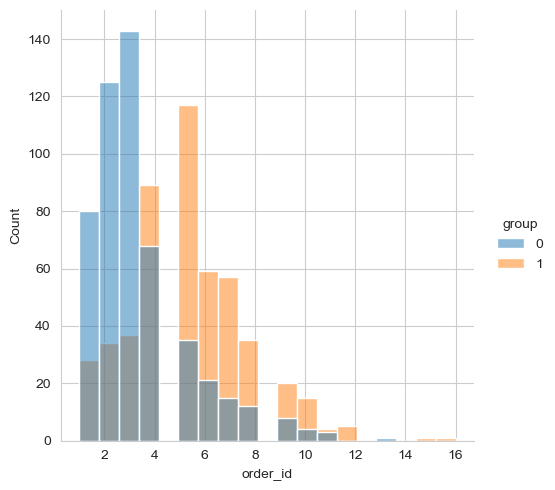

In [491]:
# а есть ли разница между группами
sns.displot(data = purchases_groups, x = 'order_id', hue = 'group')
# распределение похоже на нормальное, но скорее всего на самом деле нет - нужно проверить на выбросы для Т-теста 

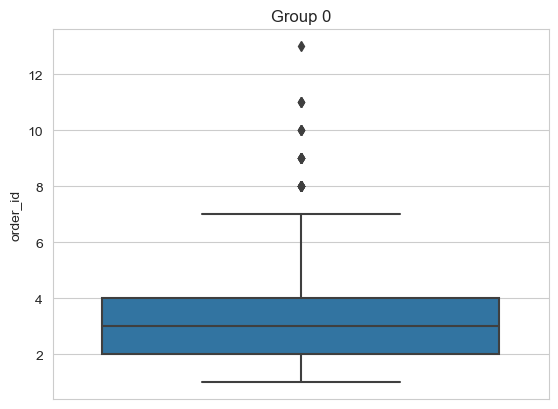

In [492]:
# есть выбросы - лучше U-тест
sns.boxplot(purchases_groups.query('group == 0'), y ='order_id')
plt.title('Group 0')
plt.show()

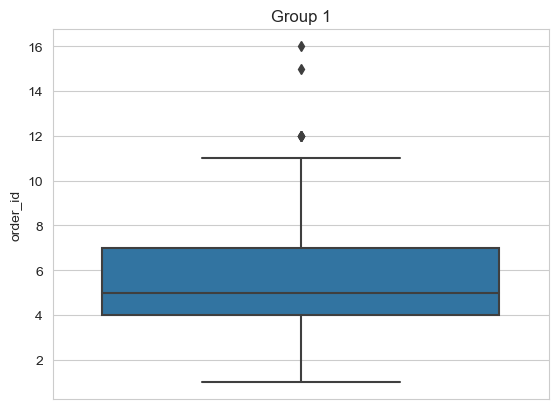

In [493]:
sns.boxplot(purchases_groups.query('group == 1'), y ='order_id')
plt.title('Group 1')
plt.show()

In [494]:
pg.mwu(x = purchases_groups.query('group == 0').order_id,
       y = purchases_groups.query('group == 1').order_id)

,U-val,alternative,p-val,RBC,CLES
MWU,62457.0,two-sided,5.200418e-47,0.51683,0.241585


Статистическая разница между группами в вопросе кол-ва покупов на 1-го пользователя - является статистически значимой, p-val	< 0.05

НО!
- ограничение для Манна-Уитни = "В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10)"

In [495]:
# условие не удовлетворено, есть повторы > 10
purchases_groups.query('group == 0').groupby('order_id').agg({ 'order_id' : 'count'})

,order_id
order_id,
1,80
2,125
3,143
4,68
5,35
6,21
7,15
8,12
9,8


In [496]:
import numpy as np

def bootstrap_independent_samples(x, y, stat_func=np.median, n_bootstrap_samples=10000):
    # Вычисляем наблюдаемую статистику
    observed_statistic = stat_func(x) - stat_func(y)
    
    # Объединяем данные
    combined_data = np.concatenate([x, y])
    
    # Создаем массив для хранения бутстрапированных статистик
    bootstrap_statistics = np.zeros(n_bootstrap_samples)
    
    # Генерируем бутстрапированные выборки и вычисляем статистику для каждой
    for i in range(n_bootstrap_samples):
        # Берем выборку с возвращением из объединенных данных
        resampled_data = np.random.choice(combined_data, size=len(combined_data), replace=True)
        # Разделяем выборки x и y
        resampled_x = resampled_data[:len(x)]
        resampled_y = resampled_data[len(x):]
        # Вычисляем статистику для бутстрапированной выборки
        bootstrap_statistics[i] = stat_func(resampled_x) - stat_func(resampled_y)
    
    # Вычисляем p-значение
    p_value = np.mean(np.abs(bootstrap_statistics) >= np.abs(observed_statistic))
    
    return observed_statistic, p_value

# Применяем функцию к выборкам x и y
observed_median_diff, p_value = bootstrap_independent_samples(x, y)

# Выводим результаты
print("Наблюдаемая разность медиан:", observed_median_diff)
print("p-значение:", p_value)


Наблюдаемая разность медиан: -2.0
p-значение: 0.0


Обнаруженная разность медиан составляет -2.0, что указывает на то, что медиана x (группа 0) больше, чем медиана y (группа 1) на 2.0.

Полученное p-значение составляет 0.0, что означает, что нулевая гипотеза (отсутствие различий между группами) отвергается на уровне значимости 0.05. Таким образом, мы можем сделать вывод о статистически значимой разнице между распределениями order_id в группах 0 и 1.

In [497]:

def bootstrap_mean_diff(x, y, n_bootstrap_samples=10000):
    # Вычисляем наблюдаемую разность средних
    observed_diff = np.mean(x) - np.mean(y)
    
    # Создаем массив для хранения бутстрапированных разностей средних
    bootstrap_diffs = np.zeros(n_bootstrap_samples)
    
    # Генерируем бутстрапированные выборки и вычисляем разность средних для каждой
    for i in range(n_bootstrap_samples):
        # Берем выборку с возвращением из каждой из выборок
        resampled_x = np.random.choice(x, size=len(x), replace=True)
        resampled_y = np.random.choice(y, size=len(y), replace=True)
        # Вычисляем средние для бутстрапированных выборок и разность между ними
        bootstrap_diffs[i] = np.mean(resampled_x) - np.mean(resampled_y)
    
    # Вычисляем p-значение как долю разностей средних, превосходящих наблюдаемую разность
    p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value

# Применяем функцию к выборкам x и y
observed_mean_diff, p_value = bootstrap_mean_diff(x, y)

# Выводим результаты
print("Наблюдаемая разность средних:", observed_mean_diff)
print("p-значение:", p_value)


Наблюдаемая разность средних: -1.9874211890302864
p-значение: 0.5031



Наблюдаемая разность средних составляет приблизительно -1.987, что означает, что среднее значение в группе x (группа 0) меньше, чем в группе y (группа 1) на примерно 1.987.

Полученное p-значение равно 0.507. Это означает, что при условии, что нулевая гипотеза верна (то есть средние значения в обеих группах равны), вероятность получить такую же или более экстремальную разницу между средними значениями, как наблюдаемая, составляет 0.507. Учитывая уровень значимости 0.05, это p-значение больше, чем уровень значимости, следовательно, нет достаточных доказательств для отвержения нулевой гипотезы о равенстве средних значений в группах.

In [498]:
# Таким образом мы не можешь утверждать о статистически значимой разнице между контрольной и тестовыми группами в вопросе изменения числа покупок на пользователя

<h2>Число заказов общее</h2>

In [499]:
# Думаю для сравнения нужно поделить контрольную и тест группы на 2 датасэта, и неотменненные зазазы
control_group = users.query(' group == 0 and action == "create_order" ' )
test_group    = users.query(' group == 1 and action == "create_order" ' )

control_group, test_group

(      user_id  order_id        action                time       date  group
 0         964      1255  create_order 2022-08-26 00:00:19 2022-08-26      0
 2         964      1257  create_order 2022-08-26 00:02:27 2022-08-26      0
 3         966      1258  create_order 2022-08-26 00:02:56 2022-08-26      0
 5         968      1261  create_order 2022-08-26 00:05:35 2022-08-26      0
 6         969      1262  create_order 2022-08-26 00:06:25 2022-08-26      0
 ...       ...       ...           ...                 ...        ...    ...
 4326     1194     59176  create_order 2022-09-08 22:18:26 2022-09-08      0
 4327     1745     59186  create_order 2022-09-08 22:20:21 2022-09-08      0
 4334     1605     59464  create_order 2022-09-08 23:22:27 2022-09-08      0
 4335     1461     59487  create_order 2022-09-08 23:29:06 2022-09-08      0
 4336     1376     59533  create_order 2022-09-08 23:41:24 2022-09-08      0
 
 [1609 rows x 6 columns],
       user_id  order_id        action          

In [500]:
contingency_table = pd.crosstab(users['group'], users['action'])
contingency_table

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


In [501]:
from scipy.stats import chi2_contingency

# Применяем Хи-квадрат тест
chi2, p, _, _ = chi2_contingency(contingency_table)

# Выводим результаты
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
if p < 0.05:
    print('Отклоняем Н_0')
else:
    print('Не отколняем Н_0')

Хи-квадрат статистика: 0.018211165651942023
p-value: 0.8926523935841298
Не отколняем Н_0


Нет статистически значимых различий между группами в распределении действий cancel_order и create_order

<h2>Products</h2>

In [502]:
products.head()
# подробная информация о продуктах, их название и стоимость

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [503]:
rows, tables = products.shape
print(f'В products строк {rows} и столбцов {tables}')
print(f'Уникальных product_id  = {products.product_id.nunique()}')
print(f'Уникальных name        = {products.name.nunique()}')

В products строк 87 и столбцов 3
Уникальных product_id  = 87
Уникальных name        = 87


In [504]:
# что по ценам
products['price'].describe()

count     87.000000
mean     133.581609
std      136.127922
min        1.000000
25%       55.000000
50%       76.300000
75%      160.000000
max      800.000000
Name: price, dtype: float64

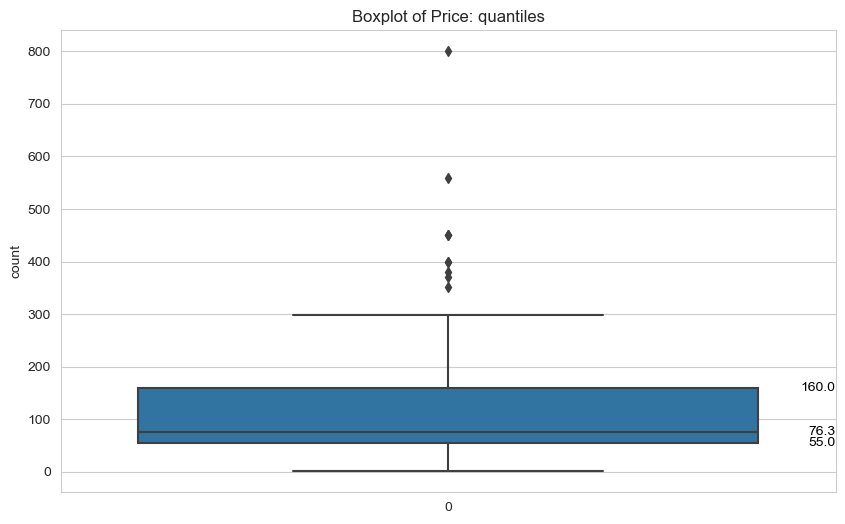

In [505]:
# Предположим, что products['price'] содержит ваши данные о ценах продуктов

# Создаем график boxplot с заданным размером
fig, ax = plt.subplots(figsize=(10, 6))

# Строим график boxplot
sns.boxplot(data=products['price'], ax=ax)

# Вычисляем квантили
quantiles = products['price'].quantile([0.25, 0.5, 0.75])

# Добавляем аннотации с квантилями
for q, val in quantiles.items():
    ax.text(0.5, val, f"{val}", ha='right', va='center', color='black', bbox=dict(facecolor='none', edgecolor='none'))

plt.ylabel('count')
plt.title('Boxplot of Price: quantiles')
plt.show()

# интересный разбос цен, но сами по себе цены ничего не говорят. лучше смотреть покупки

<h2>Orders</h2>

In [506]:
orders.head()

# подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [507]:
rows, tables = orders.shape
print(f'В orders строк {rows} и столбцов {tables}')
print(f'Уникальных order_id  = {orders.order_id.nunique()}')
print(f'Время минимум = {orders.creation_time.max()} и  и максимум = {orders.creation_time.min()}, разница = {orders.creation_time.max() - orders.creation_time.min()}')

В orders строк 4123 и столбцов 3
Уникальных order_id  = 4123
Время минимум = 2022-09-08 23:41:24 и  и максимум = 2022-08-26 00:00:19, разница = 13 days 23:41:05


In [508]:
users_orders = users.merge(orders, on = 'order_id')

In [509]:
users_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}"


In [510]:
users_orders['product_ids'] = users_orders.product_ids.str.strip('{}').str.split(', ')
users_orders_2 = users_orders.explode('product_ids')
users_orders_2 = users_orders_2.rename(columns={"product_ids": "product_id"})
users_orders_2

,user_id,order_id,action,time,date,group,creation_time,product_id
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56
...,...,...,...,...,...,...,...,...
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,9
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,62
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,77
4336,1376,59533,create_order,2022-09-08 23:41:24,2022-09-08,0,2022-09-08 23:41:24,17


In [511]:
users_orders_2['product_id'] = users_orders_2['product_id'].astype(str)

In [512]:
users_orders_2.dtypes

user_id                   int64
order_id                  int64
action                   object
time             datetime64[ns]
date             datetime64[ns]
group                     int64
creation_time    datetime64[ns]
product_id               object
dtype: object

In [514]:
products['product_id'] = products['product_id'].astype(str)

users_orders_products = users_orders_2.merge(products, on = 'product_id')

In [515]:
users_orders_products

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26 00:31:36,2022-08-26,0,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26 03:01:40,2022-08-26,1,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26 04:01:22,2022-08-26,1,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26 06:04:05,2022-08-26,1,2022-08-26 06:04:05,75,сок ананасовый,120.0
...,...,...,...,...,...,...,...,...,...,...
14564,1883,33910,create_order,2022-09-03 23:46:53,2022-09-03,1,2022-09-03 23:46:53,11,масло льняное,200.0
14565,1440,34742,create_order,2022-09-04 03:41:52,2022-09-04,0,2022-09-04 03:41:52,11,масло льняное,200.0
14566,1813,41998,create_order,2022-09-05 10:26:46,2022-09-05,1,2022-09-05 10:26:46,11,масло льняное,200.0
14567,1175,53851,create_order,2022-09-07 23:53:54,2022-09-07,0,2022-09-07 23:53:54,11,масло льняное,200.0


<h2>Стали ли юзеры больше заказывать продуктов?</h2>

In [581]:
products_count = users_orders_products.groupby(['group', 'user_id'], as_index=False).agg({ 'product_id' : 'count'}).rename(columns={'product_id' : 'products_total'})
products_count

,group,user_id,products_total
0,0,964,8
1,0,966,4
2,0,968,11
3,0,969,8
4,0,972,5
...,...,...,...
1012,1,1976,16
1013,1,1977,9
1014,1,1978,23
1015,1,1979,31


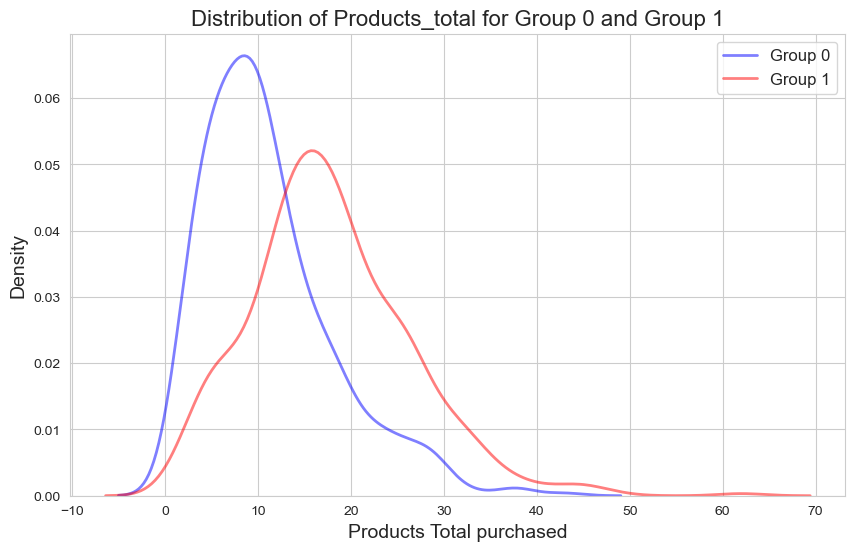

In [585]:
# Ваши данные
group0_product_ids = products_count.query('group == 0').products_total
group1_product_ids = products_count.query('group == 1').products_total

# Построение графика
plt.figure(figsize=(10, 6))
sns.kdeplot(group0_product_ids, color='blue', alpha=0.5, label='Group 0', linewidth=2)  # KDE для группы 0
sns.kdeplot(group1_product_ids, color='red', alpha=0.5, label='Group 1', linewidth=2)  # KDE для группы 1

# Дополнительные настройки графика
plt.legend(fontsize=12)
plt.xlabel('Products Total purchased', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Products_total for Group 0 and Group 1', fontsize=16)

plt.show()

In [579]:
from scipy.stats import ttest_ind
# Проведение t-теста
t_statistic, p_value = ttest_ind(products_count.query('group == 0').product_id,
                                 products_count.query('group == 1').product_id)

# Вывод результатов
print("Значение t-статистики:", t_statistic)
print("p-значение:", p_value)
# Оценка статистической значимости
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: различия статистически значимы")
else:
    print("Нет оснований отвергнуть нулевую гипотезу: различия не статистически значимы")

Значение t-статистики: -13.624031571690642
p-значение: 6.108540480706531e-39
Отвергаем нулевую гипотезу: различия статистически значимы


Опять же условия для Т-теста не выполнены, так что принимаем вывод условно!

<h2>Стали ли юзеры дороже заказывать продуктов?</h2>

In [588]:
products_sum_total = users_orders_products.groupby(['group', 'user_id'], as_index=False).agg({ 'price' : 'sum'}).rename(columns={'price' : 'price_total'})
products_sum_total

,group,user_id,price_total
0,0,964,718.9
1,0,966,170.0
2,0,968,1590.7
3,0,969,681.9
4,0,972,546.4
...,...,...,...
1012,1,1976,2001.9
1013,1,1977,781.2
1014,1,1978,3256.9
1015,1,1979,2790.7


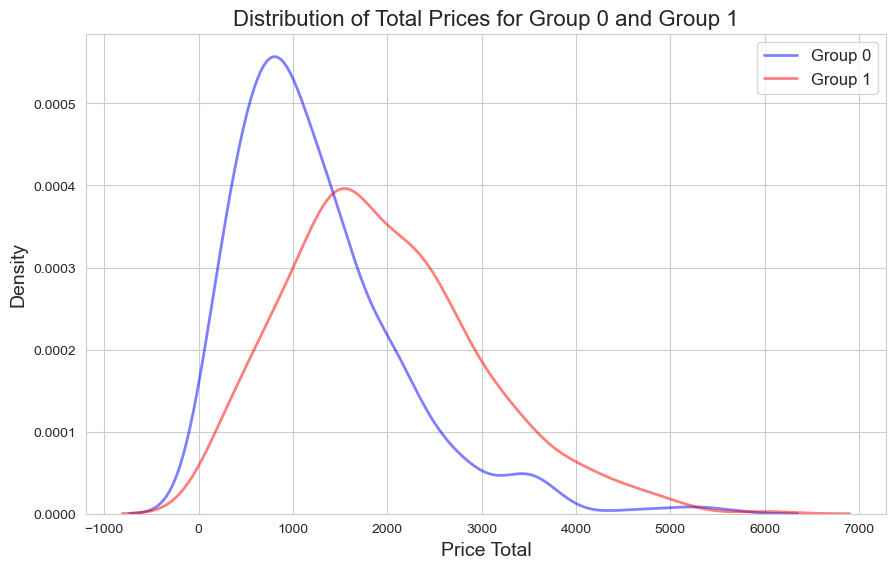

In [590]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Ваши данные
group0_prices = products_sum_total.query('group == 0').price_total
group1_prices = products_sum_total.query('group == 1').price_total

# Построение гистограмм
plt.figure(figsize=(10, 6))
sns.kdeplot(group0_prices, color='blue', alpha=0.5, label='Group 0', linewidth=2)  # Гистограмма для группы 0
sns.kdeplot(group1_prices, color='red', alpha=0.5, label='Group 1', linewidth=2)  # Гистограмма для группы 1

# Проведение t-теста
t_statistic, p_value = ttest_ind(group0_prices, group1_prices)

# Дополнительные настройки графика
plt.legend(fontsize=12)
plt.xlabel('Price Total', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Total Prices for Group 0 and Group 1', fontsize=16)

# Настройка расположения графика внутри фигуры
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.2, wspace=0.2)

plt.show()


In [591]:
from scipy.stats import ttest_ind
# Проведение t-теста
t_statistic, p_value = ttest_ind(products_sum_total.query('group == 0').price_total,
                                 products_sum_total.query('group == 1').price_total)

# Вывод результатов
print("Значение t-статистики:", t_statistic)
print("p-значение:", p_value)
# Оценка статистической значимости
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: различия статистически значимы")
else:
    print("Нет оснований отвергнуть нулевую гипотезу: различия не статистически значимы")

Значение t-статистики: -11.685795034334935
p-значение: 1.0901045699351742e-29
Отвергаем нулевую гипотезу: различия статистически значимы


Итог: 
    1) Клиенты стали закупать на большие суммы как мы видим на графике (сдвинут вправо), более того, изменения оказались значимы;
    2) То же самое касается и закупки продуктов в кол-ве, их стало больше и разница значима;
    3) Однако, мы не увидели стат.значимых различий в том, чтобы клиенты стали меньше отменять заказы;
    4) И в retention rate мы не обнаружили стат.значимых различий.
Выбор принятия решения в принятии новой системы оставим за руководством. Мы скорее за.